<a href="https://colab.research.google.com/github/2bahaa/Movie-Recommendation-System/blob/main/Movie_Recommendation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity & metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd

# Display settings
pd.set_option('display.max_columns', None)


In [10]:
# Adjust path to your dataset location
ratings_path = "/content/ml-100k/u.data"
movies_path = "/content/ml-100k/u.item"
users_path = "/content/ml-100k/u.user"

# Load ratings
ratings = pd.read_csv(ratings_path, sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Load movies
movies = pd.read_csv(movies_path, sep="|", encoding="latin-1", header=None)
movies.columns = ["movie_id", "title", "release_date", "video_release_date", "imdb_url"] + \
                 [f"genre_{i}" for i in range(19)]

# Load users
users = pd.read_csv(users_path, sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])

# Merge ratings with movie titles
ratings = ratings.merge(movies[["movie_id", "title"]], on="movie_id")
ratings.head()


,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


Number of users: 943
Number of movies: 1682
Number of ratings: 100000


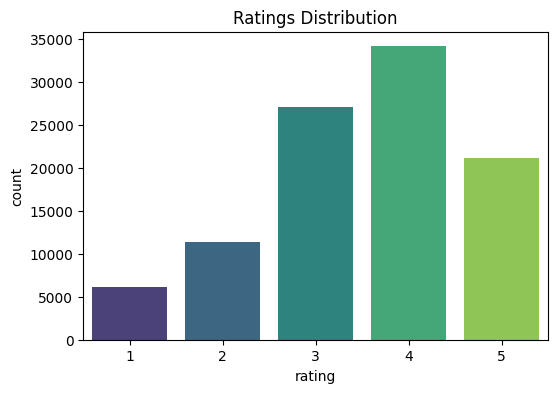

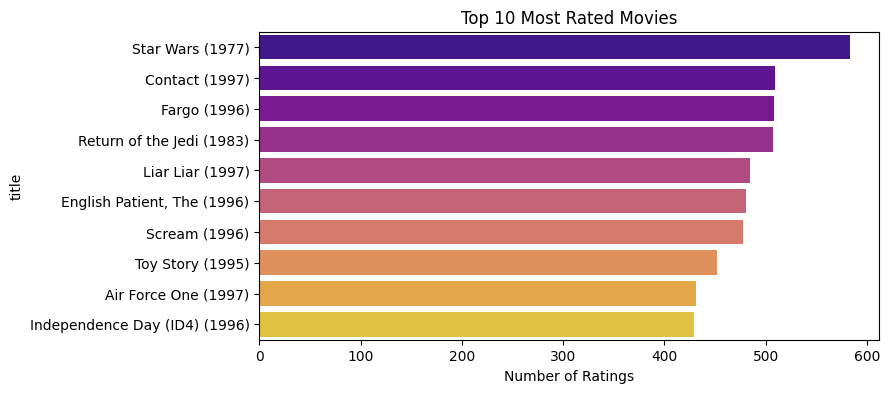

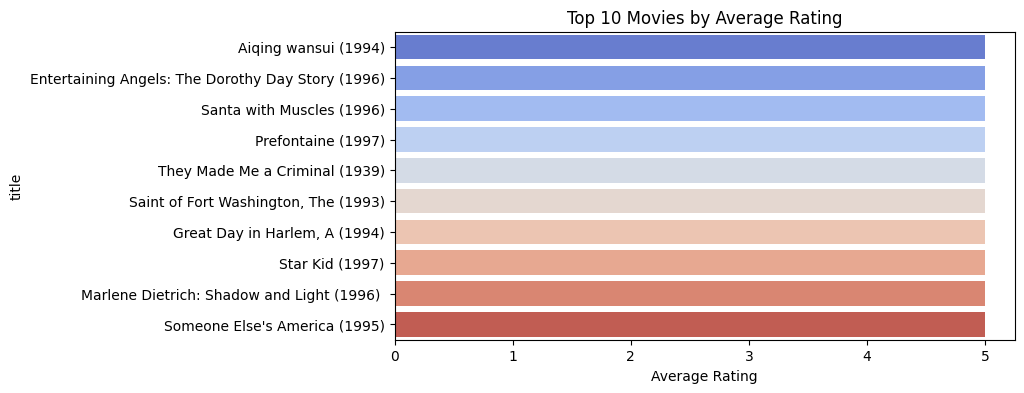

In [11]:
# Basic stats
print("Number of users:", ratings['user_id'].nunique())
print("Number of movies:", ratings['movie_id'].nunique())
print("Number of ratings:", len(ratings))

# Ratings distribution
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Ratings Distribution")
plt.show()

# Most rated movies
top_movies = ratings['title'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_movies.values, y=top_movies.index, palette="plasma")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.show()

# Average rating per movie
avg_ratings = ratings.groupby("title")["rating"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=avg_ratings.values, y=avg_ratings.index, palette="coolwarm")
plt.title("Top 10 Movies by Average Rating")
plt.xlabel("Average Rating")
plt.show()


In [12]:
user_item_matrix = ratings.pivot_table(index="user_id", columns="title", values="rating")
user_item_matrix.head()


title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   
3                              NaN           NaN                    NaN   
4                              NaN           NaN                    NaN   
5                              NaN           NaN                    2.0   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                 
1                        5.0         NaN                          NaN   
2                        NaN         NaN                          NaN   
3                        NaN         2.0                          NaN   
4                        NaN         NaN                          NaN   
5                        NaN         NaN                          NaN   

title    20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
user_id                                                                      
1                                        3.0                           4.0   
2                                        NaN                           NaN   
3                                        NaN                           NaN   
4                                        NaN                           NaN   
5                                        NaN                           4.0   

title    3 Ninjas: High Noon At Mega Mountain (1998)  39 Steps, The (1935)  \
user_id                                                                      
1                                                NaN                   NaN   
2                                                1.0                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   
5                                                NaN                   NaN   

title    8 1/2 (1963)  8 Heads in a Duffel Bag (1997)  8 Seconds (1994)  \
user_id                                                                   
1                 NaN                             NaN               NaN   
2                 NaN                             NaN               NaN   
3                 NaN                             NaN               NaN   
4                 NaN                             NaN               NaN   
5                 NaN                             NaN               NaN   

title    A Chef in Love (1996)  Above the Rim (1994)  Absolute Power (1997)  \
user_id                                                                       
1                          NaN                   NaN                    NaN   
2                          NaN                   NaN                    3.0   
3                          NaN                   NaN                    NaN   
4                          NaN                   NaN                    NaN   
5                          NaN                   NaN                    NaN   

title    Abyss, The (1989)  Ace Ventura: Pet Detective (1994)  \
user_id                                                         
1                      3.0                                3.0   
2                      NaN                                NaN   
3                      NaN                                NaN   
4                      NaN                                NaN   
5                      NaN                                NaN   

title    Ace Ventura: When Nature Calls (1995)  Across the Sea of Time (1995)  \
user_id                                                                         
1                                          NaN                            NaN   
2                                          NaN                            NaN   
3       

In [13]:
# Fill NaN with 0 for similarity calculation
user_item_filled = user_item_matrix.fillna(0)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_filled)
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_item_filled.index,
                                  columns=user_item_filled.index)
user_similarity_df.head()


user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [14]:
def recommend_movies(user_id, num_recommendations=5):
    # Get similar users
    sim_users = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)

    # Take top similar user
    top_user = sim_users.index[0]

    # Movies rated by top similar user but not by target user
    user_movies = set(user_item_matrix.loc[user_id].dropna().index)
    top_user_movies = user_item_matrix.loc[top_user].dropna().index
    recommendations = [movie for movie in top_user_movies if movie not in user_movies]

    # Sort by rating given by top user
    top_movies_sorted = user_item_matrix.loc[top_user, recommendations].sort_values(ascending=False)

    return top_movies_sorted.head(num_recommendations)

# Example
recommend_movies(1, 5)


,916
title,
Casablanca (1942),5.0
Bob Roberts (1992),5.0
"City of Lost Children, The (1995)",5.0
Wings of Desire (1987),5.0
Stealing Beauty (1996),5.0


In [16]:
from collections import defaultdict

def train_test_split_userwise(ratings_df, test_size=0.2):
    train_list = []
    test_list = []
    for user_id, group in ratings_df.groupby('user_id'):
        group = group.sample(frac=1, random_state=42)  # shuffle
        cutoff = int(len(group) * (1 - test_size))
        train_list.append(group.iloc[:cutoff])
        test_list.append(group.iloc[cutoff:])
    return pd.concat(train_list), pd.concat(test_list)

# New split
train, test = train_test_split_userwise(ratings, test_size=0.2)

# Build user-item matrix from train
train_matrix = train.pivot_table(index="user_id", columns="title", values="rating")
train_matrix_filled = train_matrix.fillna(0)
train_similarity = cosine_similarity(train_matrix_filled)
train_similarity_df = pd.DataFrame(train_similarity, index=train_matrix_filled.index, columns=train_matrix_filled.index)

def recommend_movies_topn(user_id, num_recommendations=5, topn_users=10):
    sim_users = train_similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(topn_users)
    weighted_scores = defaultdict(float)
    sim_sum = defaultdict(float)

    for sim_user, sim_score in sim_users.items():
        for movie, rating in train_matrix.loc[sim_user].dropna().items():
            if pd.isna(train_matrix.loc[user_id, movie]):
                weighted_scores[movie] += sim_score * rating
                sim_sum[movie] += sim_score

    predicted_scores = {m: weighted_scores[m] / sim_sum[m] for m in weighted_scores}
    return sorted(predicted_scores, key=predicted_scores.get, reverse=True)[:num_recommendations]

# Evaluate over all users
precisions = []
for user_id in test['user_id'].unique():
    actual = test[test['user_id'] == user_id]['title'].tolist()
    predicted = recommend_movies_topn(user_id, num_recommendations=5)
    precisions.append(precision_at_k(actual, predicted, 5))

print("Average Precision@5:", np.mean(precisions))


Average Precision@5: 0.043690349946977736


In [17]:
# Compute cosine similarity between items
item_similarity = cosine_similarity(user_item_filled.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_filled.columns,
                                  columns=user_item_filled.columns)

def recommend_item_based(movie_title, num_recommendations=5):
    similar_items = item_similarity_df[movie_title].drop(movie_title).sort_values(ascending=False)
    return similar_items.head(num_recommendations)

# Example
recommend_item_based("Star Wars (1977)")


,Star Wars (1977)
title,
Return of the Jedi (1983),0.884476
Raiders of the Lost Ark (1981),0.764885
"Empire Strikes Back, The (1980)",0.749819
Toy Story (1995),0.734572
"Godfather, The (1972)",0.697332


In [18]:
# Fill NaN with 0
R = user_item_filled.values

# Perform SVD
U, Sigma, VT = randomized_svd(R, n_components=20, random_state=42)

# Reconstruct matrix
R_hat = np.dot(np.dot(U, np.diag(Sigma)), VT)

# Convert back to DataFrame
predicted_ratings_df = pd.DataFrame(R_hat, index=user_item_filled.index, columns=user_item_filled.columns)

def recommend_svd(user_id, num_recommendations=5):
    # Sort by predicted rating
    user_pred = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    known_movies = user_item_matrix.loc[user_id].dropna().index
    recommendations = user_pred.drop(known_movies).head(num_recommendations)
    return recommendations

# Example
recommend_svd(1, 5)


,1
title,
Trainspotting (1996),3.857716
Sense and Sensibility (1995),3.302360
"Close Shave, A (1995)",3.279793
E.T. the Extra-Terrestrial (1982),3.269992
Schindler's List (1993),3.245300


In [19]:
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


# Paths to MovieLens files
ratings_path = "/content/ml-100k/u.data"
movies_path = "/content/ml-100k/u.item"

# Ratings
ratings = pd.read_csv(ratings_path, sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Movies
movies = pd.read_csv(movies_path, sep="|", encoding="latin-1", header=None)
movies.columns = ["movie_id", "title", "release_date", "video_release_date", "imdb_url"] + \
                 [f"genre_{i}" for i in range(19)]

# Merge
ratings = ratings.merge(movies[["movie_id", "title"]], on="movie_id")
ratings.head()


,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [20]:
def train_test_split_userwise(ratings_df, test_size=0.2):
    train_list, test_list = [], []
    for user_id, group in ratings_df.groupby('user_id'):
        group = group.sample(frac=1, random_state=42)  # shuffle
        cutoff = int(len(group) * (1 - test_size))
        train_list.append(group.iloc[:cutoff])
        test_list.append(group.iloc[cutoff:])
    return pd.concat(train_list), pd.concat(test_list)

train, test = train_test_split_userwise(ratings, test_size=0.2)


In [21]:
train_matrix = train.pivot_table(index="user_id", columns="title", values="rating")
mean_ratings = train_matrix.mean(axis=1)
train_matrix_centered = train_matrix.sub(mean_ratings, axis=0)

# Fill NaN with 0 for similarity
train_matrix_centered_filled = train_matrix_centered.fillna(0)

# User similarity
user_similarity = cosine_similarity(train_matrix_centered_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

# Item similarity
item_similarity = cosine_similarity(train_matrix_centered_filled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=train_matrix.columns, columns=train_matrix.columns)


In [25]:
# Get top similar users for all users
topn_users_dict = {
    user: user_similarity_df[user].drop(user).nlargest(30).index.tolist()
    for user in user_similarity_df.index
}

# Get top similar items for all items
topn_items_dict = {
    item: item_similarity_df[item].drop(item).nlargest(100).index.tolist()
    for item in item_similarity_df.index
}


In [28]:
def recommend_hybrid_fast(user_id, k=5, alpha=0.6, topn_users=80, topn_items=200):
    user_mean = mean_ratings[user_id]

    # USER-BASED
    ub_scores = defaultdict(float)
    ub_weights = defaultdict(float)
    for sim_user in user_similarity_df[user_id].drop(user_id).nlargest(topn_users).index:
        sim_score = user_similarity_df.at[user_id, sim_user]
        for movie, rating in train_matrix_centered.loc[sim_user].dropna().items():
            if pd.isna(train_matrix.loc[user_id, movie]):
                ub_scores[movie] += sim_score * rating
                ub_weights[movie] += abs(sim_score)
    ub_final = {m: user_mean + (ub_scores[m] / ub_weights[m])
                for m in ub_scores if ub_weights[m] != 0}

    # ITEM-BASED
    ib_scores = defaultdict(float)
    ib_weights = defaultdict(float)
    for movie, rating in train_matrix.loc[user_id].dropna().items():
        for sim_movie in item_similarity_df[movie].drop(movie).nlargest(topn_items).index:
            if pd.isna(train_matrix.loc[user_id, sim_movie]):
                sim = item_similarity_df.at[movie, sim_movie]
                ib_scores[sim_movie] += sim * (rating - mean_ratings[user_id])  # mean-centered
                ib_weights[sim_movie] += abs(sim)
    ib_final = {m: mean_ratings[user_id] + (ib_scores[m] / ib_weights[m])
                for m in ib_scores if ib_weights[m] != 0}

    # HYBRID BLEND
    final_scores = {}
    all_movies = set(ub_final) | set(ib_final)
    for m in all_movies:
        final_scores[m] = alpha * ub_final.get(m, 0) + (1 - alpha) * ib_final.get(m, 0)

    return sorted(final_scores, key=final_scores.get, reverse=True)[:k]


In [29]:
precisions = [
    precision_at_k(
        test[test['user_id'] == uid]['title'].tolist(),
        recommend_hybrid_fast(uid, k=5, alpha=0.65),
        5
    )
    for uid in test['user_id'].unique()
]

print("Average Precision@5:", np.mean(precisions))


Average Precision@5: 0.0027571580063626725
